<a href="https://colab.research.google.com/github/do-huni/NLP_practice/blob/main/%EC%A0%84%EC%B0%BD%EC%9A%B1%20%EB%93%B1.%20(2022)%2C%20%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%202%EC%99%80%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C%20%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%2C%20%EC%9C%84%ED%82%A4%EB%B6%81%EC%8A%A4/chat_bot_sequence2sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RUN_ALL_CODES**

##**I. Download Data and Visualize**

###**&nbsp;1. Downloading Data**

In [1]:
!pip install transformers
!pip install KoNLPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 48.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import re
import os
from konlpy.tag import Okt
from konlpy.tag import Twitter
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
DATA_IN_PATH = './data_in/'
data = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv')

In [5]:
os.makedirs('./data_in', exist_ok = True)
data.to_csv('./data_in/ChatBotData.csv')

In [6]:
print(data.head())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [7]:
questions = list(data['Q'])
answers = list(data['A'])
sentences = questions + answers

###**&nbsp;2. Visualization of All Sentences**

In [ ]:
tokenized_sentences = [s.split() for s in sentences]
len_token_unit_sentences = [len(i) for i in tokenized_sentences]
len_syllable_unit_sentences = [len(re.sub(' ', '',i)) for i in sentences]

okt = Okt()
morph_tokenized_sentences = [okt.morphs(re.sub(' ', '', i)) for i in sentences]
len_morph_unit_sentences = [len(i) for i in morph_tokenized_sentences]

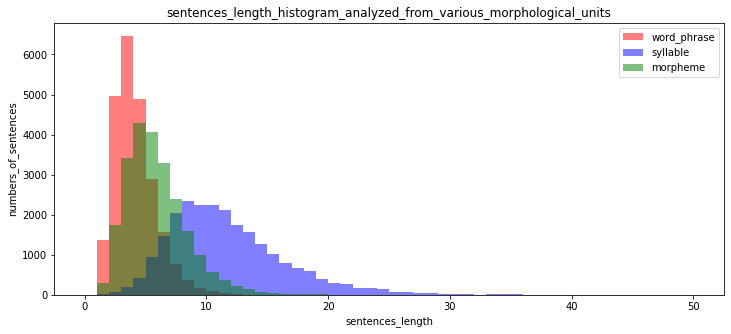

In [ ]:
plt.figure(figsize = (12,5))
plt.hist(len_token_unit_sentences, bins = 50 , range = [0,50], alpha = 0.5, color = 'r', label = 'word_phrase')
plt.hist(len_syllable_unit_sentences, bins = 50, range = [0,50], alpha = 0.5, color = 'b', label = 'syllable')
plt.hist(len_morph_unit_sentences, bins = 50, range = [0,50], alpha = 0.5, color = 'g', label = 'morpheme')
plt.title('sentences_length_histogram_analyzed_from_various_morphological_units')
plt.xlabel('sentences_length')
plt.ylabel('numbers_of_sentences')
plt.legend(loc = 'best')

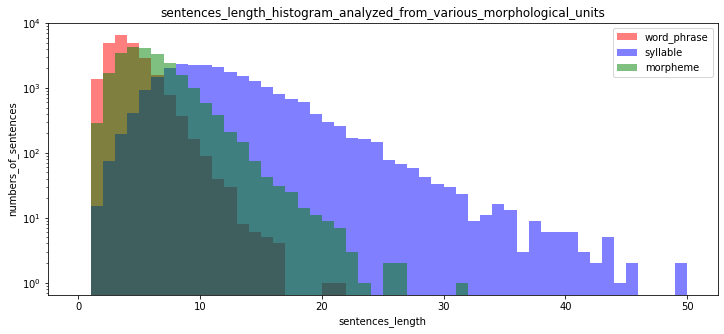

In [ ]:
plt.figure(figsize = (12,5))
plt.hist(len_token_unit_sentences, bins = 50 , range = [0,50], alpha = 0.5, color = 'r', label = 'word_phrase')
plt.hist(len_syllable_unit_sentences, bins = 50, range = [0,50], alpha = 0.5, color = 'b', label = 'syllable')
plt.hist(len_morph_unit_sentences, bins = 50, range = [0,50], alpha = 0.5, color = 'g', label = 'morpheme')
plt.title('sentences_length_histogram_analyzed_from_various_morphological_units')
plt.xlabel('sentences_length')
plt.ylabel('numbers_of_sentences')
plt.yscale('log') #y축 스케일 값을 log로 변경
plt.legend(loc = 'best')

In [ ]:
lens = [len_token_unit_sentences, len_syllable_unit_sentences, len_morph_unit_sentences]
lens_max, lens_min, lens_mean, lens_std, lens_median = {},{},{},{},{}
names = ['token', 'syllable', 'morpheme']
for i in range(len(lens)):
  name = names[i]
  lens_max[name] = np.max(lens[i])
  lens_min[name] = np.min(lens[i])
  lens_mean[name] = np.mean(lens[i])
  lens_std[name] = np.std(lens[i])
  lens_median[name] = np.median(lens[i])

In [ ]:
pd.DataFrame([lens_max, lens_min, lens_mean, lens_std, lens_median], index = ['max', 'min', 'mean', 'standard', 'median']).transpose()

,max,min,mean,standard,median
token,21.0,1.0,3.640531,1.742913,3.0
syllable,57.0,1.0,11.306563,4.978838,10.0
morpheme,31.0,1.0,5.412543,2.560910,5.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fed34cf5310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fed34ba55e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fed345f5e20>,
 'medians': [<matplotlib.lines.Line2D at 0x7fed34c24df0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fed34ce71f0>,
 'means': [<matplotlib.lines.Line2D at 0x7fed352b0280>,
  <matplotlib.lines.Line2D at 0x7fed353aa970>]}

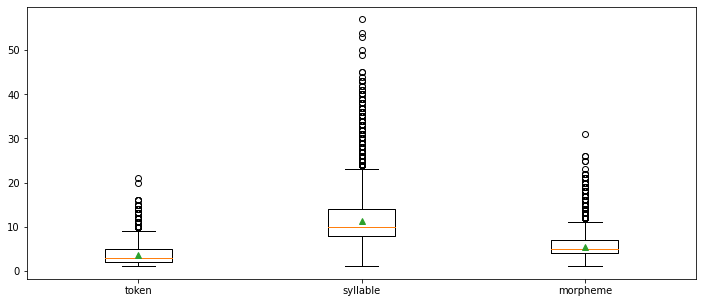

In [ ]:
plt.figure(figsize =(12,5))
plt.boxplot(lens, labels = names, showmeans = True)

Text(0.5, 1.0, 'length of questions & answers')

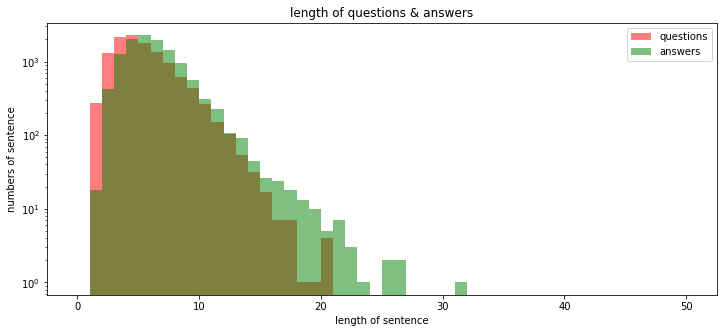

In [ ]:
plt.figure(figsize = (12,5))
plt.hist(len_morph_unit_questions, bins = 50, range = [0,50], alpha = 0.5, color = 'r', label = 'questions')
plt.hist(len_morph_unit_answers, bins = 50, range = [0,50], alpha = 0.5,  color = 'g', label = 'answers')
plt.xlabel('length of sentence')
plt.ylabel('numbers of sentence')
plt.legend(loc = 'best')
plt.yscale('log')
plt.title('length of questions & answers')

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'whiskers': [<matplotlib.lines.Line2D at 0x7fed319acb80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fed319a9280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fed319ac820>,
 'medians': [<matplotlib.lines.Line2D at 0x7fed319a99a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fed319a9ca0>,
 'means': []}

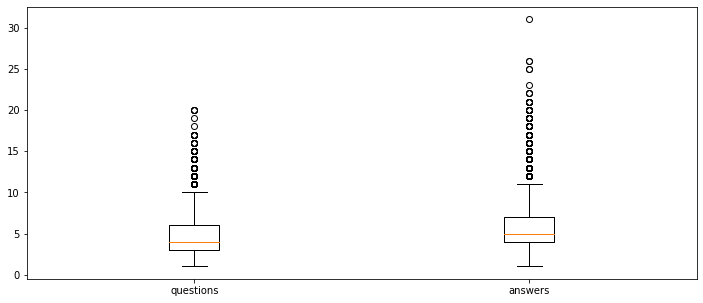

In [ ]:
plt.figure(figsize = (12,5))
plt.boxplot([len_morph_unit_questions, len_morph_unit_sentences], labels = ['questions', 'answers'])

###**&nbsp;3. Visualization of Questions**

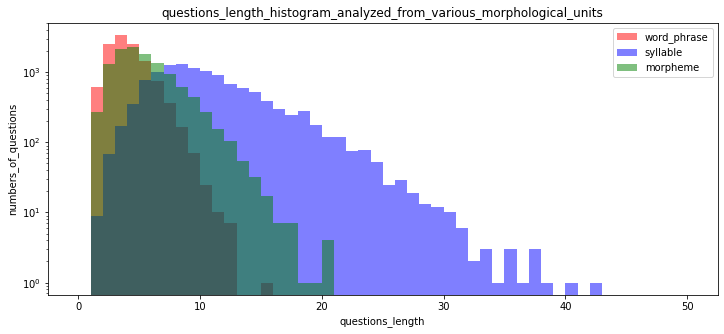

In [ ]:
tokenized_questions = [s.split() for s in questions]
len_token_unit_questions = [len(i) for i in tokenized_questions]
len_syllable_unit_questions = [len(re.sub(' ', '',i)) for i in questions]

okt = Okt()
morph_tokenized_questions = [okt.morphs(re.sub(' ', '', i)) for i in questions]
len_morph_unit_questions = [len(i) for i in morph_tokenized_questions]



plt.figure(figsize = (12,5))
plt.hist(len_token_unit_questions, bins = 50 , range = [0,50], alpha = 0.5, color = 'r', label = 'word_phrase')
plt.hist(len_syllable_unit_questions, bins = 50, range = [0,50], alpha = 0.5, color = 'b', label = 'syllable')
plt.hist(len_morph_unit_questions, bins = 50, range = [0,50], alpha = 0.5, color = 'g', label = 'morpheme')
plt.title('questions_length_histogram_analyzed_from_various_morphological_units')
plt.xlabel('questions_length')
plt.ylabel('numbers_of_questions')
plt.yscale('log')
plt.legend(loc = 'best')

In [ ]:
lens = [len_token_unit_questions, len_syllable_unit_questions, len_morph_unit_questions]
lens_max, lens_min, lens_mean, lens_std, lens_median = {},{},{},{},{}
names = ['token', 'syllable', 'morpheme']
for i in range(len(lens)):
  name = names[i]
  lens_max[name] = np.max(lens[i])
  lens_min[name] = np.min(lens[i])
  lens_mean[name] = np.mean(lens[i])
  lens_std[name] = np.std(lens[i])
  lens_median[name] = np.median(lens[i])
pd.DataFrame([lens_max, lens_min, lens_mean, lens_std, lens_median], index = ['max', 'min', 'mean', 'standard', 'median']).transpose()

,max,min,mean,standard,median
token,15.0,1.0,3.587414,1.618828,3.0
syllable,42.0,1.0,10.291635,4.739911,9.0
morpheme,20.0,1.0,4.950436,2.482297,4.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fed32d9bfa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fed32d926a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fed32d9bc40>,
 'medians': [<matplotlib.lines.Line2D at 0x7fed32d92d60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fed32da7400>,
 'means': [<matplotlib.lines.Line2D at 0x7fed32da70a0>,
  <matplotlib.lines.Line2D at 0x7fed32d40760>]}

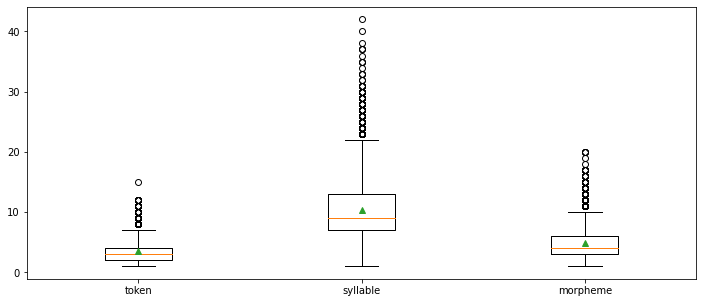

In [ ]:
plt.figure(figsize =(12,5))
plt.boxplot(lens, labels = names, showmeans = True)

###**&nbsp;4. Visualization of Answers**

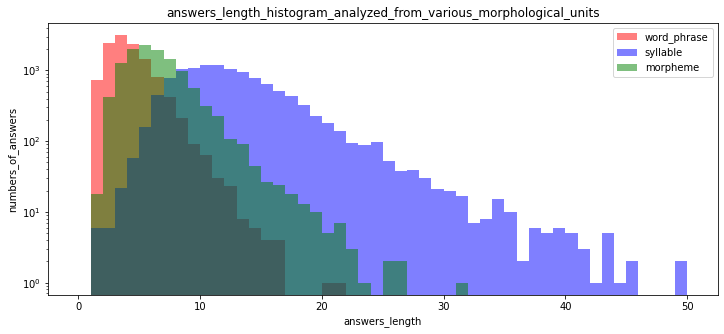

In [ ]:
tokenized_answers = [s.split() for s in answers]
len_token_unit_answers = [len(i) for i in tokenized_answers]
len_syllable_unit_answers = [len(re.sub(' ', '',i)) for i in answers]

okt = Okt()
morph_tokenized_answers = [okt.morphs(re.sub(' ', '', i)) for i in answers]
len_morph_unit_answers = [len(i) for i in morph_tokenized_answers]



plt.figure(figsize = (12,5))
plt.hist(len_token_unit_answers, bins = 50 , range = [0,50], alpha = 0.5, color = 'r', label = 'word_phrase')
plt.hist(len_syllable_unit_answers, bins = 50, range = [0,50], alpha = 0.5, color = 'b', label = 'syllable')
plt.hist(len_morph_unit_answers, bins = 50, range = [0,50], alpha = 0.5, color = 'g', label = 'morpheme')
plt.title('answers_length_histogram_analyzed_from_various_morphological_units')
plt.xlabel('answers_length')
plt.ylabel('numbers_of_answers')
plt.yscale('log')
plt.legend(loc = 'best')

In [ ]:
lens = [len_token_unit_answers, len_syllable_unit_answers, len_morph_unit_answers]
lens_max, lens_min, lens_mean, lens_std, lens_median = {},{},{},{},{}
names = ['token', 'syllable', 'morpheme']
for i in range(len(lens)):
  name = names[i]
  lens_max[name] = np.max(lens[i])
  lens_min[name] = np.min(lens[i])
  lens_mean[name] = np.mean(lens[i])
  lens_std[name] = np.std(lens[i])
  lens_median[name] = np.median(lens[i])
pd.DataFrame([lens_max, lens_min, lens_mean, lens_std, lens_median], index = ['max', 'min', 'mean', 'standard', 'median']).transpose()

,max,min,mean,standard,median
token,21.0,1.0,3.693648,1.857214,3.0
syllable,57.0,1.0,12.321492,5.005072,11.0
morpheme,31.0,1.0,5.874651,2.554924,5.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fed31f0e4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fed31f0ebb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fed31f0e190>,
 'medians': [<matplotlib.lines.Line2D at 0x7fed31f042b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fed31f04910>,
 'means': [<matplotlib.lines.Line2D at 0x7fed31f045b0>,
  <matplotlib.lines.Line2D at 0x7fed31f26c70>]}

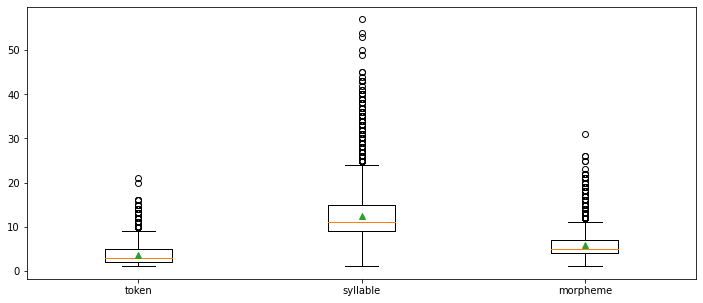

In [ ]:
plt.figure(figsize =(12,5))
plt.boxplot(lens, labels = names, showmeans = True)

##**II. Seq_to_Seq Model**

###**&nbsp;1. Modeling Preprocessing Steps**

In [8]:
#NAMESPACE
FILTERS = "([~.,!?\"':;)(])"

#tokens
PAD = "<PAD>"
STD = "<SOS>" #Start of Sequence
END = "<END>" #End of Sequence
UNK = "<UNK>" #Unknown

#indexes
PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

MAX_SEQUENCE = 25

In [9]:
def load_data(path):
  data_df = pd.read_csv(path, header = 0)
  question, answer = list(data_df['Q']), list(data_df['A'])

  return question, answer

In [10]:
def data_tokenizer(data):
  words = [] #word_dictionary
  for sentence in data:
    sentence = re.sub(CHANGE_FILTER, '', sentence) #Removing Special Symbols
    for word in sentence.split():
      words.append(word)
  return [word for word in words if word] #exclude empty element

In [11]:
def morpheme_tokenizer(data):
  morph_analyzer = Okt()
  result_data = []
  for seq in tqdm(data):
    morpheme_seq = ' '.join(morph_analyzer.morphs(re.sub(' ', '', seq)))
    result_data.append(morpheme_seq)

  return result_data

In [12]:
def load_word_dictionary(path, vocab_path, tokenize_into_morphemes = False):
  word_dictionary = []
  if not os.path.exists(vocab_path):
    if os.path.exists(path):
      data_df = pd.read_csv(path, encoding = 'utf-8')
      question, answer = list(data_df['Q']), list(data_df["A"])
      if tokenize_into_morphemes:
        question = morpheme_tokenizer(question)
        answer = morpheme_tokenizer(answer)
      
      data = []
      data.extend(question)
      data.extend(answer)
      words= data_tokenizer(data)
      words = list(set(words)) #excluding overlapped words
      words[:0] = MARKER
    
    with open(vocab_path, 'w', encoding = 'utf-8') as vocabulary_file:
      for word in words:
        vocabulary_file.write(word + '\n')
    
  with open(vocab_path, 'r', encoding = 'utf-8') as vocabulary_file:
    for line in vocabulary_file:
      word_dictionary.append(line.strip())
  
  word2idx, idx2word = make_vocabulary(word_dictionary)

  return word2idx, idx2word, len(word2idx)

In [13]:
def make_vocabulary(word_dictionary):
  word2idx = {word: idx for idx, word in enumerate(word_dictionary)}
  idx2word = {idx: word for idx, word in enumerate(word_dictionary)}
  
  return word2idx, idx2word

In [14]:
def enc_preprocessing(value, dictionary, tokenize_into_morphemes = False):
  sequences_input_index = []
  sequences_length = []

  if tokenize_into_morphemes:
    value = morpheme_tokenizer(value)
  
  for sequence in value:
    sequence = re.sub(CHANGE_FILTER, "", sequence)
    sequence_index = []
    for word in sequence.split():
      if dictionary.get(word) is not None:
        sequence_index.extend([dictionary[word]])
      else:
        sequence_index.extend([dictionary[UNK]])
    
    if len(sequence_index) > MAX_SEQUENCE:
      sequence_index = sequence_index[:MAX_SEQUENCE]
  
    sequences_length.append(len(sequence_index))
    sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]

    sequences_input_index.append(sequence_index)
  
  return np.asarray(sequences_input_index), sequences_length

In [15]:
def dec_output_preprocessing(value, dictionary, tokenize_into_morphemes = False):
  sequences_output_index = []
  sequences_length = []

  if tokenize_into_morphemes:
    value = morpheme_tokenizer(value)
  
  for sequence in value:
    sequence = re.sub(CHANGE_FILTER, "", sequence)
    sequence_index = []
    sequence_index = [dictionary[STD]] + [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]

    if len(sequence_index) > MAX_SEQUENCE:
      sequence_index = sequence_index[:MAX_SEQUENCE]

    sequences_length.append(len(sequence_index))
    sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]

    sequences_output_index.append(sequence_index)
  
  return np.asarray(sequences_output_index), sequences_length

In [16]:
def dec_target_preprocessing(value, dictionary, tokenize_into_morphemes = False):
  sequences_target_index = []

  if tokenize_into_morphemes:
    value = morpheme_tokenizer(value)
  
  for sequence in value:
    sequence = re.sub(CHANGE_FILTER, "", sequence)
    sequence_index = [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]

    if len(sequence_index) >= MAX_SEQUENCE:
      sequence_index = sequence_index[:MAX_SEQUENCE -1] +[dictionary[END]]
    else:
      sequence_index += [dictionary[END]]

    sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
    sequences_target_index.append(sequence_index)
  
  return np.asarray(sequences_target_index)

###**&nbsp;2. Preprocessing**

In [17]:
PATH = 'data_in/ChatBotData.csv'
VOCAB_PATH = 'data_in/vocabulary.txt'

inputs, outputs = load_data(PATH)
char2idx, idx2char, vocab_size = load_word_dictionary(PATH, VOCAB_PATH, tokenize_into_morphemes = False)

In [18]:
index_inputs, input_seq_len = enc_preprocessing(inputs, char2idx, tokenize_into_morphemes = False)
index_outputs, output_seq_len = dec_output_preprocessing(outputs, char2idx, tokenize_into_morphemes = False)
index_targets = dec_target_preprocessing(outputs, char2idx, tokenize_into_morphemes = False)

In [19]:
data_configs = {}
data_configs['char2idx'] = char2idx
data_configs['idx2char'] = idx2char
data_configs['vocab_size'] = vocab_size
data_configs['pad_symbol'] = PAD
data_configs['std_symbol'] = STD
data_configs['end_symbol'] = END
data_configs['unk_symbol'] = UNK

In [20]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUTS  = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_IN_PATH + TRAIN_INPUTS, 'wb'), index_inputs)
np.save(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'wb'), index_outputs)
np.save(open(DATA_IN_PATH + TRAIN_TARGETS, 'wb'), index_targets)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'))

###**&nbsp;3. Modeling**

In [21]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

#from preprocess import *

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [23]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS  = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [24]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [25]:
print(len(index_inputs), len(index_outputs), len(index_targets))

11823 11823 11823


In [26]:
#Hyper Parameters
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 50
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

In [27]:
#Encoder
class Encoder(tf.keras.layers.Layer):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim

    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences = True,
                                   return_state =True,
                                   recurrent_initializer = 'glorot_uniform')
    
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
  
  def initialize_hidden_state(self, inp):
    return tf.zeros((tf.shape(inp)[0], self.enc_units))

In [28]:
#Attention
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query,1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    
    attention_weights = tf.nn.softmax(score, axis = 1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [29]:
#Decoder
class Decoder(tf.keras.layers.Layer):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder,self).__init__()

    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim

    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
    self.fc = tf.keras.layers.Dense(self.vocab_size)

    self.attention = Attention(self.dec_units)
  
  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector,1), x], axis = -1)

    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))

    x= self.fc(output)

    return x, state, attention_weights

In [30]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype = loss_.dtype)
  return tf.reduce_mean(loss_)

def accuracy(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1)
  pred *= mask
  acc =train_accuracy(real, pred)

  return tf.reduce_mean(acc)

In [52]:
class seq2seq(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx= 2):
    super(seq2seq, self).__init__()
    self.end_token_idx = end_token_idx
    self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
    self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)

  def call(self, x):
    inp, tar =x

    enc_hidden = self.encoder.initialize_hidden_state(inp)
    enc_output, enc_hidden = self.encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    predict_tokens = []
    for t in range(0, tar.shape[1]):
      dec_input = tf.dtypes.cast(tf.expand_dims(tar[:,t],1), tf.float32)
      predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
      predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
    
    return tf.stack(predict_tokens, axis=1)
  
  def inference(self, x):
    inp = x

    enc_hidden = self.encoder.initialize_hidden_state(inp)
    enc_output, enc_hidden = self.encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([char2idx[std_index]],1)

    predict_tokens = []
    for t in range(0, MAX_SEQUENCE):
      predictions, dec_hidden, _= self.decoder(dec_input, dec_hidden, enc_output)
      predict_token = tf.argmax(predictions[0])

      if predict_token == self.end_token_idx:
        break
      
      predict_tokens.append(predict_token)
      dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)

    return tf.stack(predict_tokens, axis = 0).numpy()

In [53]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss= loss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [accuracy])

In [33]:
PATH = DATA_OUT_PATH + MODEL_NAME
os.makedirs(os.path.join(PATH), exist_ok = True)

checkpoint_path = DATA_OUT_PATH + MODEL_NAME +'/weights.h5'

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor = 'val_accuracy', verbose =1, save_best_only =True, save_weights_only = True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 10)

In [34]:
history = model.fit([index_inputs, index_outputs], index_targets, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALIDATION_SPLIT, callbacks = [earlystop_callback, cp_callback])

Epoch 1/10
5320/5320 [==============================] - ETA: 0s - loss: 1.2905 - accuracy: 0.8492
Epoch 1: val_accuracy improved from -inf to 0.85265, saving model to ./data_out/seq2seq_kor/weights.h5
5320/5320 [==============================] - 849s 153ms/step - loss: 1.2905 - accuracy: 0.8492 - val_loss: 1.4841 - val_accuracy: 0.8526
Epoch 2/10
5320/5320 [==============================] - ETA: 0s - loss: 1.1066 - accuracy: 0.8538
Epoch 2: val_accuracy improved from 0.85265 to 0.85483, saving model to ./data_out/seq2seq_kor/weights.h5
5320/5320 [==============================] - 809s 152ms/step - loss: 1.1066 - accuracy: 0.8538 - val_loss: 1.5067 - val_accuracy: 0.8548
Epoch 3/10
5320/5320 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.8560
Epoch 3: val_accuracy improved from 0.85483 to 0.85682, saving model to ./data_out/seq2seq_kor/weights.h5
5320/5320 [==============================] - 809s 152ms/step - loss: 1.0085 - accuracy: 0.8560 - val_loss: 1.5956 - v

In [78]:
#load_weights
model.built = vocab_size
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [83]:
question_ex = '여자친구 선물 추천해줘'

test_index_inputs, _ = enc_preprocessing([question_ex], char2idx)
predict_tokens = model.inference(test_index_inputs)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

같이 여행을 떠나보세요


In [84]:
predict_tokens

array([16845, 19402, 14143])

In [90]:
def chat_bot(input_str):
  index_input_, _ = enc_preprocessing([input_str], char2idx)
  predict_tokens = model.inference(index_input_)

  return(' '.join([idx2char[str(t)] for t in predict_tokens]))

In [91]:
chat_bot('여자친구 선물 추천해줘')

'같이 여행을 떠나보세요'

In [ ]:
!pip install gradio
import gradio as gr

In [93]:
iface=gr.Interface(
    fn=chat_bot,
    inputs=gr.inputs.Textbox(lines=2,placeholder="문장을 입력하시오."),
    outputs = 'text'
)

iface.launch(share = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ab96a3b9-2609-47cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
